# Challenge Objective
Use machine learning and image processing to detect the location of V-beat in Electrocardiogram (ECG), given a collection of ECG strip images 

* There is a collection of ECG strip (n=540) in 'train' folder. Each data is an image of ECG plot together with its annotation (label). Figure below is one of the example from the training data. 
* The vertical line indicates the position of the beat signal. Above that line, there is a label that indicates the type of the beat signal. The V-beat is the one with label 'V'. 
* There are grid boxes in the plots, each box correspond to 0.2 second horizontally and 0.5 miliVolt vertically. 

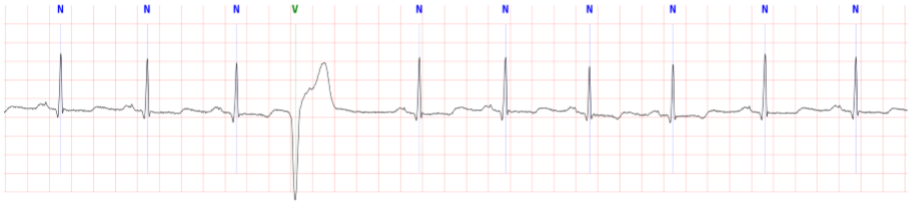

* By having training data images in 'train' folder (n=540), ﬁnd the location of V-beat for each testing data image in 'test' folder (n=180) as shown below:

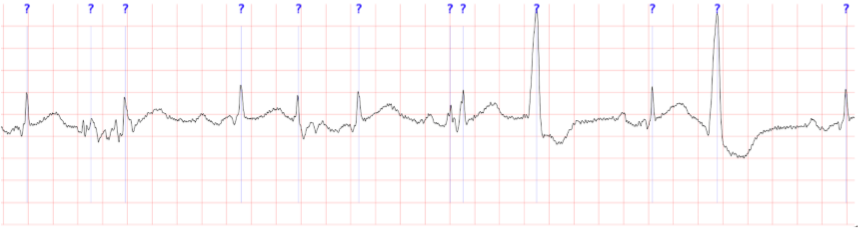

* Present your prediction of testing data in a csv ﬁle: The ﬁrst column is the ﬁlename; The second column is location of V-beat in seconds. For example:

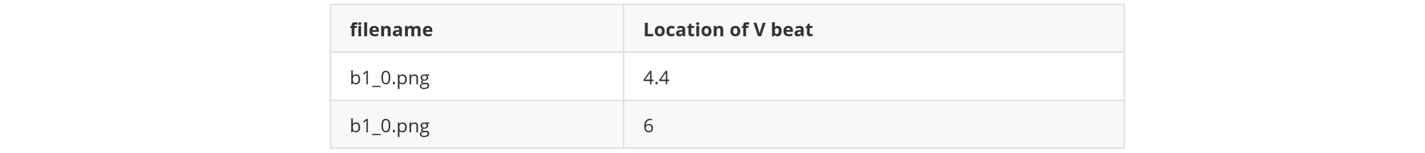

## Additional reference
* What is Electrocardiogram (ECG)? 
https://en.wikipedia.org/wiki/Electrocardiography
* What is V-beat? (Premature ventricular contraction)
https://en.wikipedia.org/wiki/Premature_ventricular_contraction
* Features of V-beats: peak-to-peak interval, peak amplitude, peak inverted. https://github.com/JNYH/ecg_vbeat/blob/master/v-beats-features.pdf

Configuration in folder:

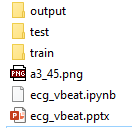

In [17]:
# !pip install imutils
# !pip install opencv-python   #to install cv2

In [18]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
%config InlineBackend.figure_formats = ['retina']
from imutils import paths
import time   # time1 = time.time(); print('Time taken: {:.1f} sec'.format(time.time() - time1))
SEED = 71
import cv2
import pickle
import warnings
warnings.filterwarnings("ignore")
from statistics import mean, median
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve

Populating the interactive namespace from numpy and matplotlib


In [15]:
## to plot graph using x_list and y_list
def show_graph(x_list, y_list, width, height):
    """ x_list, y_list = x- & y-coordinates to plot
        width, height = size of plot
    """
    plt.figure(figsize = [width, height])   # [width, height]
    plt.scatter(x_list, y_list, marker='.', s=5)
    plt.show()
    return 

## to locate position of "V" (dark green) or "N" (blue) or "?-mark" (blue)
def locate_pos(image, color):
    """ image = image file read by cv2.imread('filename.png')
        color = color of "V" (dark green) or "N" (blue) or "?-mark" (blue)
        returns a list of x-coordinates positions
    """
    position_list = []
    y_level = 42
    while len(position_list) == 0 and y_level < 100:
        x=100           # start position, not too close to left boundary
        while x<7422:   # end position, not too close to right boundary
            if np.all(image[y_level][x] == color):
                position_list.append(x)
                x += 25   # skip the alphabet which has a width of 20 pixels
            x += 1   # increment to next pixel
        y_level+=2
    return position_list

## to extract y-coordinates for x = 1 to 160, y = 1 to 750
def extract_feat(image, begin, end):
    """ image = image to read pixel
        begin = start index (include) of x-coordinate 
        end = end+1 index (exclude) of x-coordinate
        returns a list of y-coordinates & summary statistics 
    """
    # (i) to extract y-coordinates
    x_list, y_list = [], [350]   # boundary condition for y_list, padding average value 350
    for x in np.arange(begin, end, 1):
        #x_list.append(x-begin)   # output x will range from 0 to 159
        for y in np.arange(0, 750, 1):
            if np.all(image[y][x] == (0, 0, 0)):   # look for black dot
                y_list.append(750-y)   # invert the graph, so the origin becomes bottom left
                break
            if y==749:   # if there is no black dot in the column, append previous point
                y_list.append(y_list[x-begin])
    y_list.pop(0)   # remove boundary condition for y_list, index 0 (ie, 350)
    #show_graph(x_list, y_list, 2, 2)   #need x_list
    
    # (ii) to extract summary statistics, ie, min, mean, median, max
    y_list.extend( find_stats(y_list, 0, 40) )   # quardrant 1
    y_list.extend( find_stats(y_list, 40, 80) )   # quardrant 2
    y_list.extend( find_stats(y_list, 80, 120) )   # quardrant 3
    y_list.extend( find_stats(y_list, 120, 160) )   # quardrant 4
    y_list.extend( find_stats(y_list, 0, 80) )   # segment 1 (quardrant 1&2)
    y_list.extend( find_stats(y_list, 40, 120) )   # segment 2 (quardrant 2&3)
    y_list.extend( find_stats(y_list, 80, 160) )   # segment 3 (quardrant 3&4)
    
    return y_list

## to extract summary statistics from y-coordinates in given range, ie, min, mean, median, max
def find_stats(y_list, begin, end):
    """ y_list = given list to look for statistics
        begin = start index (include) of list
        end = end index+1 (exclude) of list
        returns a list [min, mean, median, max]
    """
    temp_list = []
    for i in np.arange(begin, end, 1):
        temp_list.append(y_list[i])
    return [min(temp_list), mean(temp_list), median(temp_list), max(temp_list)]

## Explore the dataset, image pre-processing

In [19]:
## try 1 image
image = cv2.imread('a3_45.png')
image.shape

(750, 7522, 3)

In [20]:
print(image[0][0])   # top-left, first pixel is white
# [255, 255, 255] = white
# [0, 0, 0] = black
# [255, 0, 0] = blue
# [0, 128, 0] = dark green

[255 255 255]


In [21]:
image[749][7521]   # bottom-right, last pixel is also white

array([255, 255, 255], dtype=uint8)

Time taken: 35.8 sec


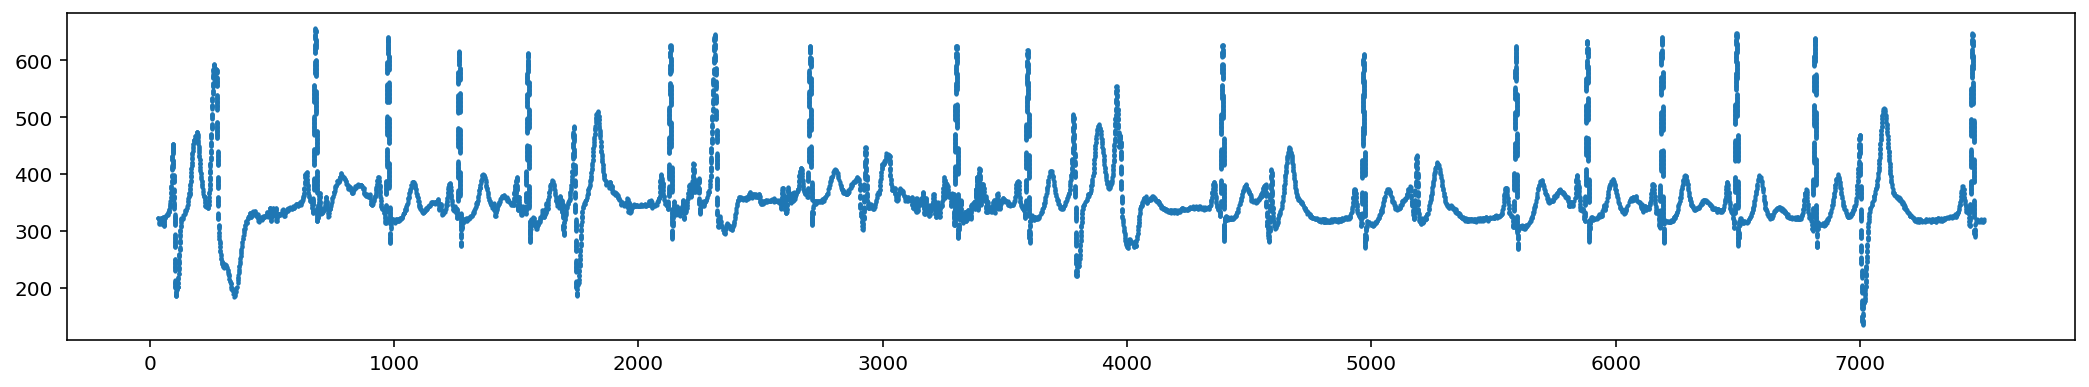

In [22]:
# to extract black pixel from the entire image, 7522 x 750 pixel
image = cv2.imread('a3_45.png')
time1 = time.time() 
x_list, y_list = [], []

for x in np.arange(0, 7522, 1):
    for y in np.arange(0, 750, 1):
        if np.all(image[y][x] == (0, 0, 0)):   # black
            x_list.append(x)
            y_list.append(750-y)

print('Time taken: {:.1f} sec'.format(time.time() - time1))
show_graph(x_list, y_list, 18, 3)

In [ ]:
# # to locate position of "V" (dark green color)
# image = cv2.imread('a3_45.png')
# position_list = []
# x=100   # start position, not too close to left boundary
# while x<7422:   # end position, not too close to right boundary
#     if np.all(image[45][x] == (0, 128, 0)):
#         position_list.append(x)
#         x += 25
#     x += 1

# print('Number of V-beat found: ', len(position_list))

# # to extract data points for V-beat graph
# i = 0   # to iterate for position[i]
# x_list, y_list = [0], [0]   # boundary condition
# begin = position_list[i]-70
# end = position_list[i]+90
# for x in np.arange(begin, end, 1):
#     x_list.append(x-begin)
#     for y in np.arange(0, 750, 1):
#         if np.all(image[y][x] == (0, 0, 0)):   # look for black dot
#             y_list.append(750-y)
#             break
#         if y==749:   # if there is no black dot in the column, append previous point
#             y_list.append(y_list[x-begin])
# x_list.pop(0)   # remove boundary condition
# y_list.pop(0)   # remove boundary condition
# print(len(x_list), x_list)
# print(y_list)
# show_graph(x_list, y_list, 2, 5)

# i = 2   # to iterate for position[i]
# x_list, y_list = [0], [0]   # boundary condition
# begin = position_list[i]-70
# end = position_list[i]+90
# for x in np.arange(begin, end, 1):
#     x_list.append(x-begin)
#     for y in np.arange(0, 750, 1):
#         if np.all(image[y][x] == (0, 0, 0)):   # look for black dot
#             y_list.append(750-y)
#             break
#         if y==749:   # if there is no black dot in the column, append previous point
#             y_list.append(y_list[x-begin])
# x_list.pop(0)   # remove boundary condition
# y_list.pop(0)   # remove boundary condition
# print(len(x_list), x_list)
# print(y_list)
# show_graph(x_list, y_list, 2, 5)

In [ ]:
# # to locate position of "N" (blue color)
# image = cv2.imread('a3_45.png')
# position_list = []
# x=100   # start position, not too close to left boundary
# while x<7422:   # end position, not too close to right boundary
#     if np.all(image[45][x] == (255, 0, 0)):   # (blue color)
#         position_list.append(x)
#         x += 25
#     x += 1

# print('Number of N found: ', len(position_list))

# # to extract data points for N graph
# i = 0   # to iterate for position[i]
# x_list, y_list = [0], [0]   # boundary condition
# begin = position_list[i]-70
# end = position_list[i]+90
# for x in np.arange(begin, end, 1):
#     x_list.append(x-begin)
#     for y in np.arange(0, 750, 1):
#         if np.all(image[y][x] == (0, 0, 0)):   # look for black dot
#             y_list.append(750-y)
#             break
#         if y==749:   # if there is no black dot in the column, append previous point
#             y_list.append(y_list[x-begin-1])
# x_list.pop(0)   # remove boundary condition
# y_list.pop(0)   # remove boundary condition
# print(len(x_list), x_list)
# print(y_list)
# show_graph(x_list, y_list, 2, 5)

In [264]:
# # this is the way to refer to images in folder (from imutils import paths)
# imagePaths = sorted(list(paths.list_images('try_train')))   # small dataset in 'try_train' folder for trying
# random.seed(SEED)
# random.shuffle(imagePaths)
# imagePaths   #output: ['try\\a3_45.png', 'try\\a1_0.png', 'try\\a4_80.png', 'try\\a6_83.png']

['try\\a3_45.png', 'try\\a1_0.png', 'try\\a4_80.png', 'try\\a6_83.png']

## TRAIN dataset: image processing, features extraction, train-test split

In [33]:
# image processing for TRAIN dataset
time1 = time.time()
train_X, train_y = [], []   # initialise for features extraction

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images('train')))
random.seed(SEED)
random.shuffle(imagePaths)

# loop over the input images
image_count = 0
for imagePath in imagePaths:
    image_count+=1
    image = cv2.imread(imagePath)
    
    ## (A) to locate position of "V" (dark green color)
    position_list = locate_pos(image, (0, 128, 0))   # (dark green color)
    count = len(position_list)
    print('\nNumber of V-beat found: ', count)
    # to extract data points for V-beat
    for i in range(count):   # to iterate for position[i]
        print('V', i, end=', ')
        train_X.append( extract_feat(image, position_list[i]-70, position_list[i]+90) )   # list of features
        train_y.append( 1 )   # integer
        
    ## (B) to locate position of "N" (blue color)
    position_list = locate_pos(image, (255, 0, 0))   # (blue color)
    if len(position_list) < count:   # N usually more than V-beat
        count = len(position_list)
    elif len(position_list) > (count+2):   # to balance the dataset (for n V-beat found extract n+2 N-beat)
        count = count + 2
    # to extract data points for N
    for i in range(count):   # to iterate for position[i]
        print('N', i, end=', ')
        train_X.append( extract_feat(image, position_list[i]-70, position_list[i]+90) )   # list of features
        train_y.append( 0 )   # integer
        
print('\nTotal images processed: ', image_count)
print('Time taken: {:.1f} sec'.format(time.time() - time1))


Number of V-beat found:  0
N 0, N 1, 
Number of V-beat found:  5
V 0, V 1, V 2, V 3, V 4, N 0, N 1, N 2, N 3, N 4, N 5, N 6, 
Number of V-beat found:  3
V 0, V 1, V 2, N 0, N 1, N 2, N 3, N 4, 
Number of V-beat found:  9
V 0, V 1, V 2, V 3, V 4, V 5, V 6, V 7, V 8, N 0, N 1, N 2, N 3, N 4, N 5, N 6, N 7, N 8, N 9, N 10, 
Number of V-beat found:  6
V 0, V 1, V 2, V 3, V 4, V 5, N 0, N 1, N 2, N 3, N 4, N 5, N 6, N 7, 
Number of V-beat found:  0
N 0, N 1, 
Number of V-beat found:  0
N 0, N 1, 
Number of V-beat found:  8
V 0, V 1, V 2, V 3, V 4, V 5, V 6, V 7, N 0, N 1, N 2, N 3, N 4, N 5, N 6, N 7, N 8, N 9, 
Number of V-beat found:  0
N 0, N 1, 
Number of V-beat found:  3
V 0, V 1, V 2, N 0, N 1, N 2, N 3, N 4, 
Number of V-beat found:  0
N 0, N 1, 
Number of V-beat found:  4
V 0, V 1, V 2, V 3, N 0, N 1, N 2, N 3, N 4, N 5, 
Number of V-beat found:  0
N 0, N 1, 
Number of V-beat found:  0
N 0, N 1, 
Number of V-beat found:  0
N 0, N 1, 
Number of V-beat found:  0
N 0, N 1, 
Number of 

In [34]:
print(len(train_X))   # a list of lists (each list is 160 y-coordinates + 28 summary statistics)
print(len(train_y))   # a list of 1113 '1's and 2098 '0's

3211
3211


In [35]:
# create pandas dataframe, and save TRAIN dataset
df = pd.DataFrame()
df['train_X'] = train_X
df['train_y'] = train_y

df.to_csv('train_dataset.csv', index=False)

# df = pd.read_csv('train_dataset.csv')
# train_X, train_y = df.drop('train_y',axis=1), df['train_y']
# # note: after loading, train_X and train_y are not of type 'list' anymore!! Training accuracy reduces a lot!

In [36]:
df['train_y'].value_counts()

0    2098
1    1113
Name: train_y, dtype: int64

In [37]:
train_y.count(0)   # 2098 '0's

2098

In [38]:
train_y.count(1)  # 1113 '1's

1113

In [39]:
# # DO NOT convert to array!!! Somehow the features are useless in an array.
# X = np.array(train_X)
# print(len(X))
# y = np.array(train_y)
# print(len(y))

In [40]:
type(train_y)   # before train_test_split, type: list

list

In [41]:
# split data to 80:20 ratio for train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=.2, random_state=SEED)
print('len(X_train)', len(X_train))
print('len(y_train)', len(y_train))
print('len(X_test)', len(X_test))
print('len(y_test)', len(y_test))

len(X_train) 2568
len(y_train) 2568
len(X_test) 643
len(y_test) 643


In [42]:
type(y_train)   # after train_test_split, type: list

list

## Model: train/fit model, tune hyperparameter

In [43]:
def model_report(model_name, model):
    print('\nSearch for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data')
    model.fit(X_train, y_train)
    global optimal_th
    optimal_th = 0.5   # start with default threshold value
    
    for i in range(0,3):   # loop through 3 dec pl to look for optimal threshold
        score_list = []
        print('\nLooping decimal place', i+1) 
        th_list = [np.linspace(optimal_th-0.4999, optimal_th+0.4999, 11), 
                  # eg [ 0.0001 , 0.1008, 0.2006, 0.3004, 0.4002, 0.5, 0.5998, 0.6996, 0.7994, 0.8992, 0.9999 ]
                 np.linspace(optimal_th-0.1, optimal_th+0.1, 21), 
                  # eg 0.3xx [ 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ]
                 np.linspace(optimal_th-0.01, optimal_th+0.01, 21)]
                  # eg 0.30x [ 0.29 , 0.291, 0.292, 0.293, 0.294, 0.295, 0.296, 0.297, 0.298, 0.299, 0.3  , 0.301, 0.302, 0.303, 0.304, 0.305, 0.306, 0.307, 0.308, 0.309, 0.31 ]
        for th in th_list[i]:
            y_pred = (model.predict_proba(X_test)[:,1] >= th)
            f1scor = f1_score(y_test, y_pred)
            score_list.append(f1scor)
            print('{:.3f}->{:.4f}'.format(th, f1scor), end=',  ')   # display score in 4 decimal pl
        optimal_th = float(th_list[i][score_list.index(max(score_list))])

    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    print('optimal threshold = {:.3f}'.format(optimal_th))

    print('\n', model_name, 'accuracy score is')
    print('Training: {:.2f}%'.format(100*model.score(X_train, y_train)))  # score uses accuracy
    print('Validation: {:.2f}%'.format(100*model.score(X_test, y_test)))   # should use cross validation

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.25)
    print('\nAdjust threshold to 0.25:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = model.predict(X_test)
    print('\nDefault threshold of 0.50:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.75)
    print('\nAdjust threshold to 0.75:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= optimal_th)
    print('\nOptimal threshold {:.3f}'.format(optimal_th))
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    
    #global model_f1, model_auc, model_ll, model_roc_auc
    #model_f1 = f1_score(y_test, y_pred)

    y_pred = model.predict_proba(X_test)
    model_ll = log_loss(y_test, y_pred)
    print(model_name, 'Log-loss: {:.4f}'.format(model_ll))
    y_pred = model.predict(X_test)
    model_roc_auc = roc_auc_score(y_test, y_pred)
    print(model_name, 'roc_auc_score: {:.4f}'.format(model_roc_auc)) 
    y_pred = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    model_auc = auc(fpr, tpr)
    print(model_name, 'AUC: {:.4f}'.format(model_auc))

    # plot the ROC curve
    plt.figure(figsize = [6,6])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % model_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
    
    return


"""""" LogisticRegression """"""

Search for optimal hyperparameter C, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data
0.9955, 0.9949, 0.9955, 0.9955, 0.9949, 0.9949, 0.9944, 0.9944, 0.9949, 0.9949, 0.9949, 0.9955, 0.9944, 0.9955, 0.9949, 0.9944, 0.9955, 0.9949, 0.9949, 0.9949, optimal cv F1 score = 0.9955
optimal value of C = 0.001

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.8321,  0.100->1.0000,  0.200->1.0000,  0.300->1.0000,  0.400->1.0000,  0.500->1.0000,  0.600->1.0000,  0.700->0.9978,  0.800->0.9978,  0.900->0.9978,  1.000->0.9406,  
Looping decimal place 2
0.000->0.8139,  0.010->0.9933,  0.020->0.9978,  0.030->1.0000,  0.040->1.0000,  0.050->1.0000,  0.060->1.0000,  0.070->1.0000,  0.080->1.0000,  0.090->1.0000,  0.100->1.0000,  0.110->1.0000,  0.120->1.0000,  0.130->1.0000,  0.140->1.0000,  0.150->1.0000,  0.160->1.0000,  0.170->1.0000,  0.180->1.0000,  0.190->1.0000,  0.2

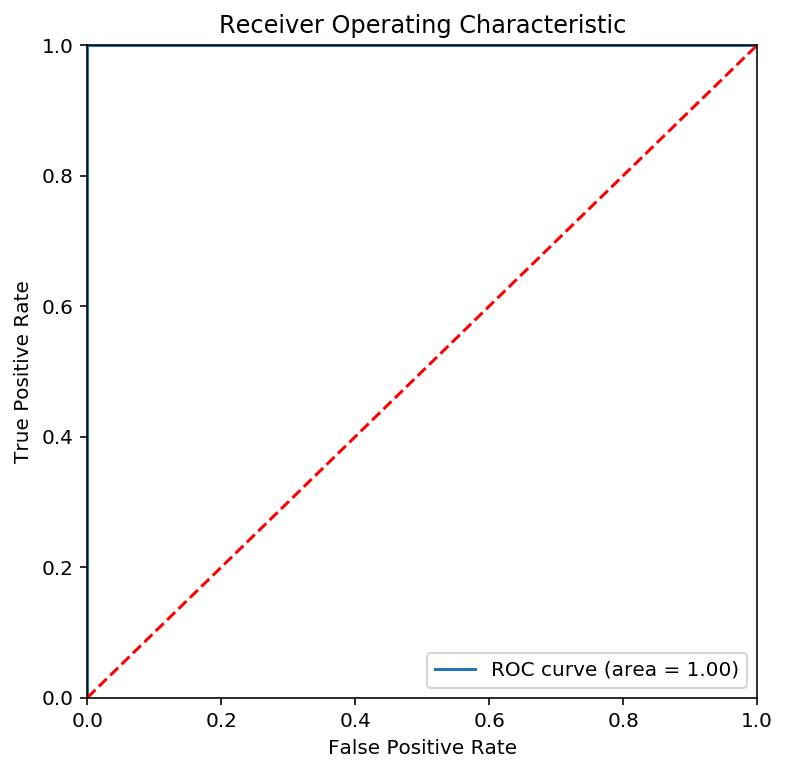

In [44]:
print('\n"""""" LogisticRegression """"""')
print('\nSearch for optimal hyperparameter C, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  # produce the k folds
score_list = []
c_list = 10**np.linspace(-3,3,20)   # loop through 20 values to look for optimal C
for c in c_list:
    logit = LogisticRegression(C = c)
    cvs = (cross_val_score(logit, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    print('{:.4f}'.format(cvs), end=', ')   # 4 decimal pl
print('optimal cv F1 score = {:.4f}'.format(max(score_list)))
optimal_c = float(c_list[score_list.index(max(score_list))])
print('optimal value of C = {:.3f}'.format(optimal_c))

logit = LogisticRegression(C = optimal_c)
model_report('LogisticRegression', logit)

In [45]:
import seaborn as sns

# to see how logistic regression confusion matrix varies with threshold
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_pred = (logit.predict_proba(X_test)[:, 1] >= threshold)
    conf = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = [5,5])
    sns.heatmap(conf, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['N', 'V-beat'],
           yticklabels=['N', 'V-beat']);
    plt.xlabel('Prediction', weight='bold')
    plt.ylabel('Actual', weight='bold')

# to see how the confusion matrix appears with changes to the cutoff! 
from ipywidgets import interactive, FloatSlider
logit = LogisticRegression(C = optimal_c)
logit.fit(X_train, y_train)
interactive(lambda threshold: make_confusion_matrix(logit, threshold), threshold=(0.0,1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [46]:
# save the model to disk
pickle.dump(logit, open('logistic_model.pickle', 'wb'))

# # load the model from disk
# logit = pickle.load(open('logistic_model.pickle', 'rb'))

## TEST dataset: image processing, use model to predict results

In [47]:
# image processing for TEST data set
time1 = time.time()
filename_list = []
location_list = []
testdata_list = []

# grab the image paths (no need shuffle)
imagePaths = sorted(list(paths.list_images('test')))

# loop over the input images
image_count = 0
for imagePath in imagePaths:
    print(imagePath)
    image_count+=1
    image = cv2.imread(imagePath)
    filename_list.append(imagePath)
    
    # to locate position of "?-mark" (blue color)
    position_list = locate_pos(image, (255, 0, 0))   # (blue color)
    count = len(position_list)
    print('Loading "?-mark" found: ', count)
    
    # to extract data points 
    test_X = []
    if count > 0:
        for i in range(count):   # to iterate for position[i]
            temp_list = extract_feat(image, position_list[i]-75, position_list[i]+85)   # returns a list of features
            test_X.append(temp_list)
            testdata_list.append( temp_list )
            print(i, end=', ')
            
        #y_pred = logit.predict(test_X)   # using default threshold 0.5, not optimised yet
        y_pred = (logit.predict_proba(test_X)[:,1] >= optimal_th)   # using optimal threshold
        y_pred = [1 if x==True else 0 if x==False else x for x in y_pred]   # .predict->0/1; .predict_proba->False/True
        print('\nPrediction:', y_pred)
        
    timing_list = []
    for i in range(len(y_pred)):
        if y_pred[i] == 1:
            timing_list.append( (round((position_list[i]-36)*(20/7450), 1)) )   # convert from pixel x-coord to sec
    print('Location(s)', timing_list)
    location_list.append(timing_list)

print('\nTotal images processed: ', image_count)
print('Time taken: {:.1f} sec'.format(time.time() - time1))

test\b1_00.png
Loading "?-mark" found:  27
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 
Prediction: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1]
Location(s) [13.9, 15.6, 17.5, 19.0]
test\b1_01.png
Loading "?-mark" found:  24
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
Prediction: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Location(s) [0.5, 2.2, 3.8, 5.3, 6.9, 8.6, 10.0, 11.6, 13.2]
test\b1_02.png
Loading "?-mark" found:  30
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
Prediction: [0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Location(s) [3.6, 3.9, 4.6, 4.7, 5.2, 5.4, 7.1, 11.8, 15.2, 15.9, 19.7]
test\b1_03.png
Loading "?-mark" found:  24
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2

In [48]:
len(testdata_list)   # number of "?-mark" in 180 test images, 5075/180 = approx 28 per image

5075

In [49]:
# create pandas dataframe, and save test dataset
df = pd.DataFrame()
df['testdata'] = testdata_list

df.to_csv('test_dataset.csv', index=False)

In [50]:
len(location_list)   # number of test images

180

In [51]:
len(filename_list)   # number of test images

180

In [52]:
# create pandas dataframe, and save test results
df = pd.DataFrame()
df['filename'] = filename_list
df['location(sec)'] = location_list

df.to_csv('test_results.csv', index=False)

## Conclusion
The bulk of my time spent in this challenge was to prepare and process the images, extract data and turn them into features. 

The V-beat signal can be easily identified if the distinct characteristics of its shape can be translated into useful numerical/vector representation.

Machine learning (ML) models are getting more pervasive in the health technology industry, helping us do laborious tasks accurately and more efficiently.